In [2]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



warnings.filterwarnings('ignore')

In [3]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    
def createDictionary(dataframe_col1, dataframe_col2):
    """
    returns dictionary of structure number as key and and list of attribute belonging  to structure number
    :rtype: dictionary
    
    """
    # initialize the dictionary
    dictionary = {structure_number:[] for structure_number in snowfall_csv['structure_number']}
    
    for structure_number, value in zip(dataframe_col1, dataframe_col2):
        dictionary[structure_number].append(value)
    return dictionary


def createDictionaryOfMeanValue(dictionary):
    """
    returns dictionary of structure number as key and and mean values in corresponding to the structure number
    :rtype: dictionary
    
    """
    dictionary_new = {}
    
    for key, value in dictionary.items():
        mean_value = np.mean(value)
        dictionary_new[key] = mean_value
        
    return dictionary_new

def createDictionaryOfFirstValue(dictionary):
    dictionary_new = {}
    
    for key, value in dictionary.items():
        value = value[0]
        dictionary_new[key] = value
        
    return dictionary_new



In [4]:
snowfall_csv = pd.read_csv('../data-generation/NE_Counties_MERRA_by_bridge.csv', index_col=0)
d_structureNumber_county = createDictionary(snowfall_csv['structure_number'],snowfall_csv['COUNTY_NAME'])
d_structureNumber_freeze_thaw = createDictionary(snowfall_csv['structure_number'],snowfall_csv['NO_OF_FREEZE_THAW_CYCLES'])
d_structureNumber_no_of_snowfall = createDictionary(snowfall_csv['structure_number'],snowfall_csv['no_of_snowfalls'])

In [5]:
d_snowfall = createDictionaryOfMeanValue(d_structureNumber_no_of_snowfall)
d_freeze_thaw = createDictionaryOfMeanValue(d_structureNumber_freeze_thaw)
d_county = createDictionaryOfFirstValue(d_structureNumber_county)

In [6]:
csv_file = "../data-generation/04-28-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

In [7]:
df_wo[df_wo['No Change structure length'] == True].shape

(292488, 28)

In [8]:
df_wo.shape

(435482, 28)

In [9]:
df_wo = df_wo[df_wo['No Change structure length'] == True]

In [10]:
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]

In [11]:
df_wo = df_wo[df_wo['Structure Length']>6]

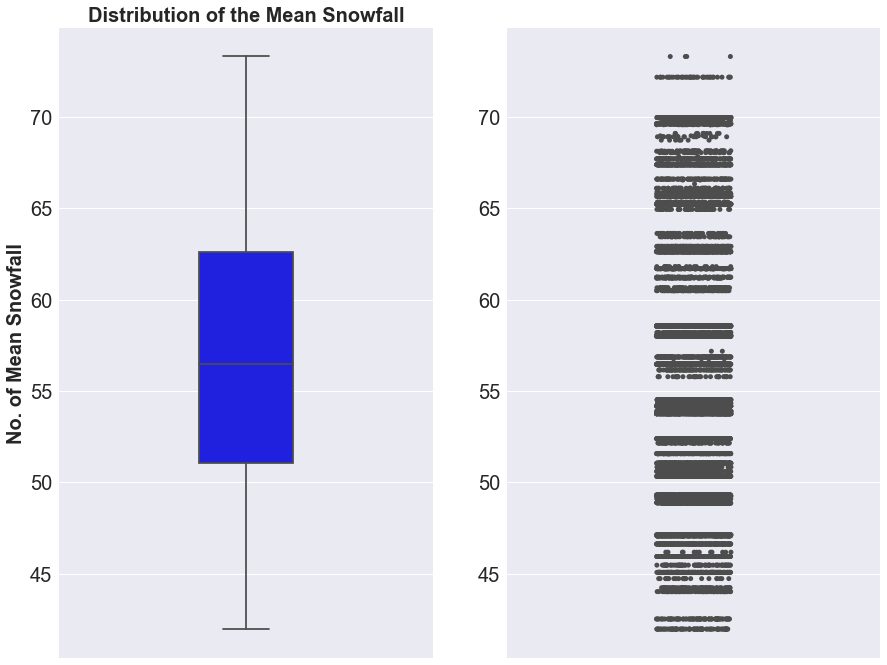

In [12]:
mean_snowfall = list(d_snowfall.values())
mean_freezethaw = list(d_freeze_thaw.values())
county_list =  list(d_county.values())

# Plotting distribution of the mean snowfall
plt.figure(figsize=(12,10))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.title("Distribution of the Mean Snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)
plt.subplot(1,2,1)
sns.boxplot(x = mean_snowfall,  color = 'blue', orient='v', width = 0.25)
plt.title("Distribution of the Mean Snowfall", fontsize = 20, fontweight = 'bold')
plt.ylabel("No. of Mean Snowfall", fontsize = 20, fontweight = "bold")

plt.subplot(1,2,2)
sns.stripplot(y= mean_snowfall, jitter=True, color=".3")
plt.show()

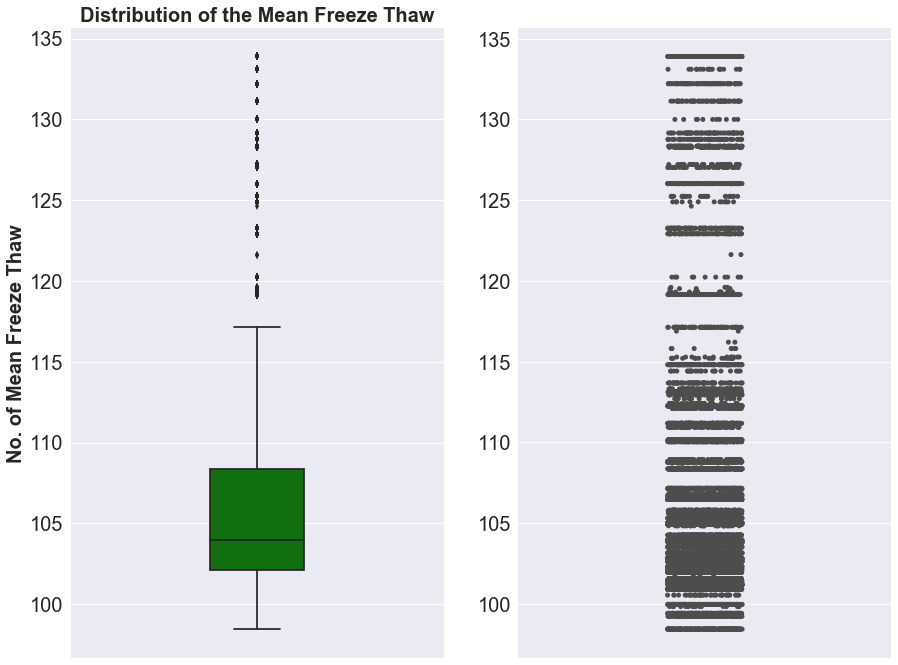

In [13]:
# Plotting distribution of the mean snowfall
plt.figure(figsize=(12,10))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.title("Distribution of the Mean Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)
plt.subplot(1,2,1)
sns.boxplot(x = mean_freezethaw,  color = 'Green', orient='v', width = 0.25)
plt.title("Distribution of the Mean Freeze Thaw", fontsize = 20, fontweight = 'bold')
plt.ylabel("No. of Mean Freeze Thaw", fontsize = 20, fontweight = "bold")

plt.subplot(1,2,2)
sns.stripplot(y= mean_freezethaw, jitter=True, color=".3")
plt.show()

In [14]:
NE = df_wo[df_wo['State Code'] == 31]
NE['SN'] = [structureNumber[:-2] for structureNumber in NE['Structure Number']]

NE['County'] = NE['SN'].map(d_county)
NE['No. of Freeze Thaw'] = NE['SN'].map(d_snowfall) 
NE['No. of Snow Fall'] = NE['SN'].map(d_freeze_thaw)

NE_clean = NE.dropna()

In [15]:
NE_clean['freezethaw'] = pd.qcut(NE_clean['No. of Freeze Thaw'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
NE_clean['snowfall'] = pd.qcut(NE_clean['No. of Snow Fall'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = NE_clean[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code',
                       'Material','Structure Type', 'Maintainer','freezethaw','snowfall']]


df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               'freezethaw':'freezethaw',\
                                               'snowfall':'snowfall'
                                             
                                               
                                              })

In [16]:
NE_clean.shape

(8859, 34)

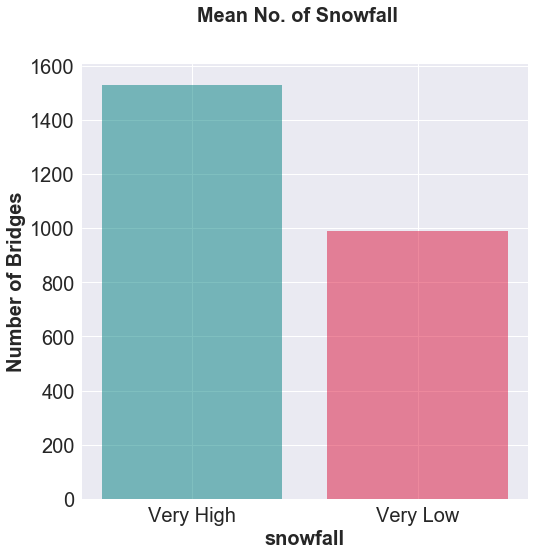

In [17]:
count_snowfall = df_anova.groupby('snowfall')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Mean No. of Snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Low", "Very High"]
no_of_records = [count_snowfall[0], count_snowfall[2]]
plt.bar(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("snowfall", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

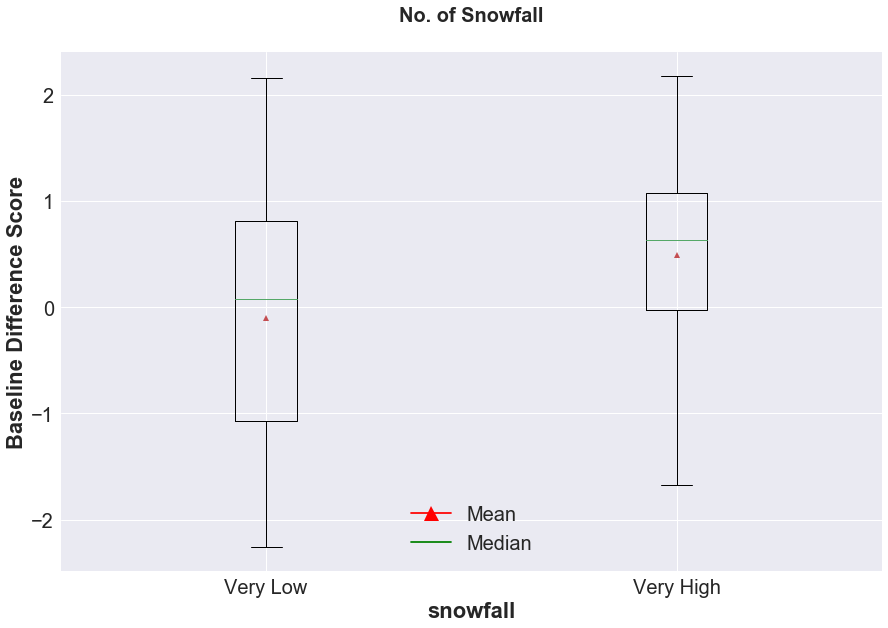

In [18]:
scores_low = df_anova[df_anova['snowfall'] == 'Very Low']['score']
scores_high = df_anova[df_anova['snowfall'] == 'Very High']['score']

scores_snowfall = [scores_low,scores_high]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')

# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("No. of Snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_snowfall, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("snowfall", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

#### ANOVA - Small Sample

In [19]:
span = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))['snowfall'].tolist()
score = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))['score'].tolist()
df_span_sample_100 = pd.DataFrame({'snowfall':span, 'score':score})
df_span_100 = df_span_sample_100[df_span_sample_100['snowfall'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(snowfall)'
span_undersample = undersample(df_span_100, 'snowfall')
aov(span_undersample, formula)


,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(snowfall),17.621412,1.0,19.071306,0.00002,0.087857,0.082869
Residual,182.947069,198.0,NaN,NaN,NaN,NaN


#### ANOVA - Large Sample

In [20]:
samplesize = min(df_anova.groupby(['snowfall'])['snowfall'].count())
span = df_anova.groupby('snowfall').apply(lambda s: s.sample(samplesize))['snowfall'].tolist()
score = df_anova.groupby('snowfall').apply(lambda s: s.sample(samplesize))['score'].tolist()
df_span_sample_45121 = pd.DataFrame({'snowfall':span, 'score':score})
df_span_45121 = df_span_sample_45121[df_span_sample_45121['snowfall'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(snowfall)'
span_undersample = undersample(df_span_45121, 'snowfall')
aov(span_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(snowfall),177.177749,1.0,198.973779,3.982733e-43,0.091315,0.090815
Residual,1763.106398,1980.0,NaN,NaN,NaN,NaN


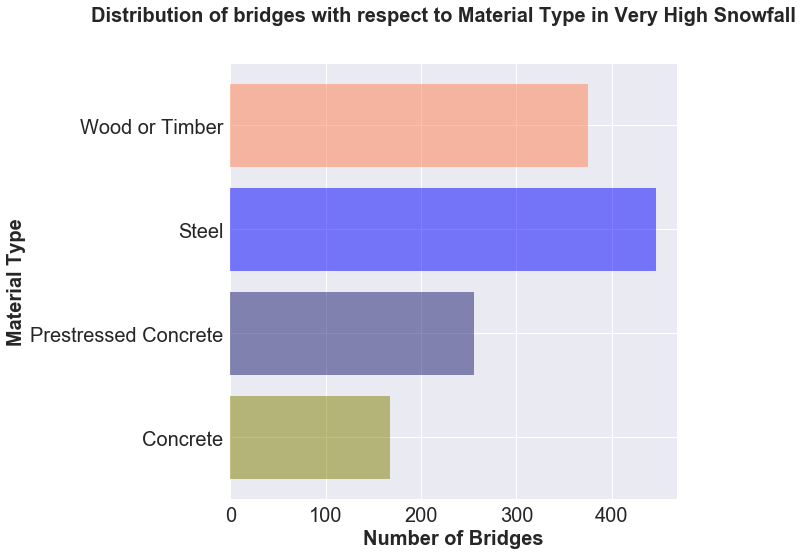

In [21]:
scores_high = df_anova[df_anova['snowfall'] == 'Very High']
scores_high['materialname'] = retMaterialNames(scores_high['material'])
low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very High Snowfall ", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

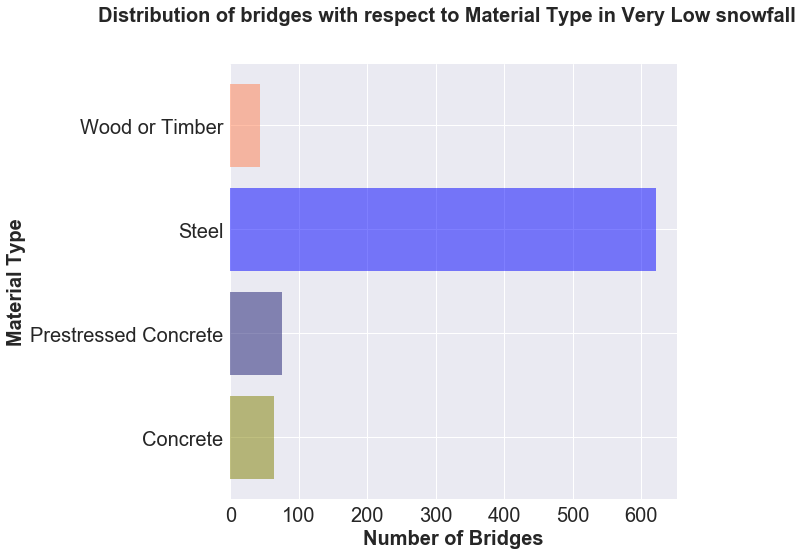

In [22]:
scores_low = df_anova[df_anova['snowfall'] == 'Very Low']
scores_low['materialname'] = retMaterialNames(scores_low['material'])
low_mat = scores_low[scores_low['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very Low snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Freeze Thaw

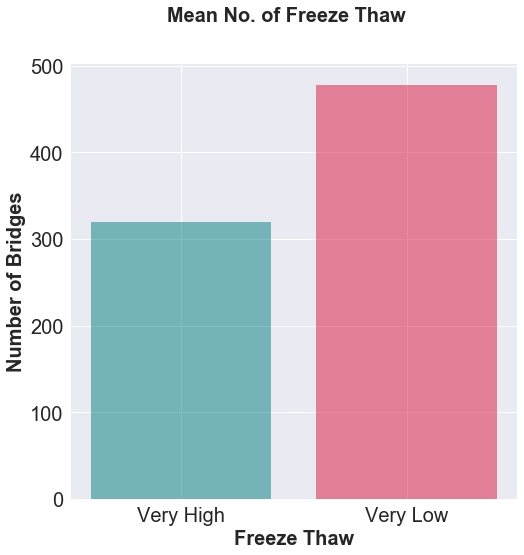

In [25]:
count_freezethaw = df_anova.groupby('freezethaw')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Mean No. of Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Low", "Very High"]
no_of_records = [count_freezethaw[0], count_freezethaw[2]]
plt.bar(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("Freeze Thaw", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

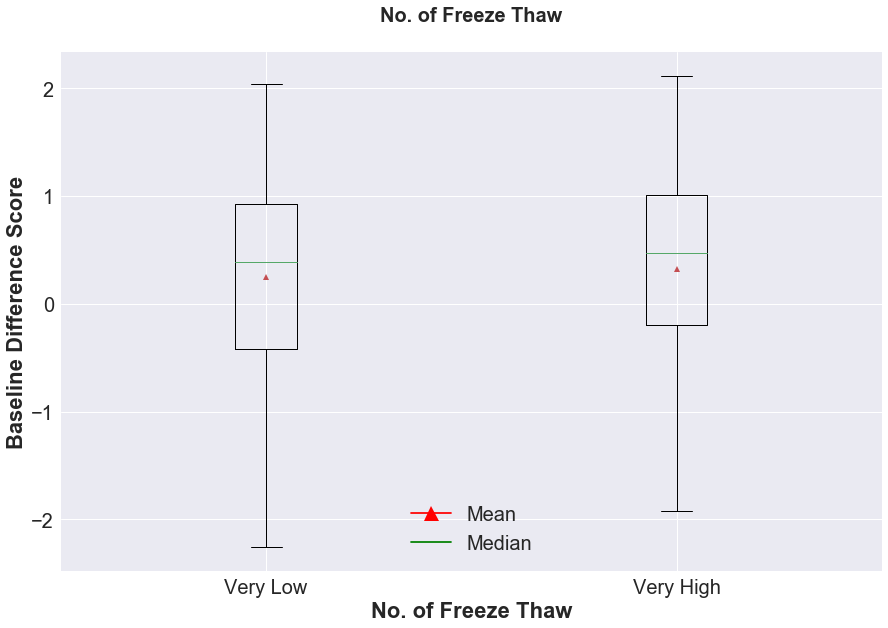

In [27]:
scores_low = df_anova[df_anova['freezethaw'] == 'Very Low']['score']
scores_high = df_anova[df_anova['freezethaw'] == 'Very High']['score']

scores_freezethaw = [scores_low,scores_high]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')

# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("No. of Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_freezethaw, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("No. of Freeze Thaw", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

In [28]:
freezethaw = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['freezethaw'].tolist()
score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['score'].tolist()
df_freezethaw_sample_100 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_100 = df_freezethaw_sample_100[df_freezethaw_sample_100['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_100, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),5.268378,1.0,6.377546,0.012341,0.031205,0.026184
Residual,163.564305,198.0,NaN,NaN,NaN,NaN


In [29]:
## 0.14

In [30]:
samplesize = min(df_anova.groupby(['freezethaw'])['freezethaw'].count())
freezethaw = df_anova.groupby('freezethaw').apply(lambda s: s.sample(samplesize))['freezethaw'].tolist()
score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(samplesize))['score'].tolist()
df_freezethaw_sample_45121 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_45121 = df_freezethaw_sample_45121[df_freezethaw_sample_45121['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_45121, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),0.760771,1.0,0.916307,0.338809,0.001434,-0.000131
Residual,529.704538,638.0,NaN,NaN,NaN,NaN


In [31]:
# 0.06

## Calculate mean construction / repair / rebuilt done on the sample of bridges from the last 10 years of NBI data in each group 